In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [18]:
df = pd.read_csv(r'C:\Users\iqra khan\OneDrive\Desktop\MSC\MachineLearning\Streamlit\Code\StrokePrediction\healthcare-dataset-stroke-data.csv')

In [19]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [20]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [22]:
# id column has no significance, we drop it
df.drop('id', inplace=True, axis= 1)

In [23]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [24]:
df['bmi'].mean()

np.float64(28.893236911794666)

In [25]:
df['bmi'].median()

np.float64(28.1)

In [26]:
# as median an mean both lie close we use mean to fill nan values
df['bmi'].fillna(df['bmi'].mean(), inplace=True)


C:\Users\iqra khan\AppData\Local\Temp\ipykernel_17412\1632754229.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


#### Separating categorical and numerical data

In [27]:

categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
'work_type', 'Residence_type', 'smoking_status']

numerical = ['age','avg_glucose_level', 'bmi']


<function matplotlib.pyplot.show(close=None, block=None)>

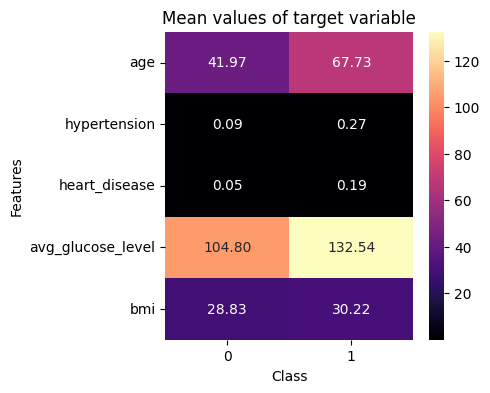

In [28]:
num_df = df.select_dtypes(include=['number'])
num_df.head()
grpd_mean = num_df.groupby('stroke').mean()
plt.figure(figsize=(4,4))
sns.heatmap(grpd_mean.T, annot = True, cmap = 'magma', fmt = '.2f')
plt.title("Mean values of target variable")
plt.xlabel('Class')
plt.ylabel('Features')
plt.show

### Exploratory Data Analysis

###### Visualising target variable to check no of occurance of stroke and no stroke

##### Univariate Analysis

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'avg_glucose_level'}>],
       [<Axes: title={'center': 'bmi'}>, <Axes: >]], dtype=object)

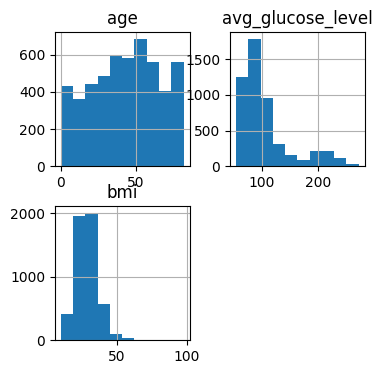

In [29]:
# for numerical features
df[numerical].hist(figsize=(4,4))

<Axes: ylabel='Density'>

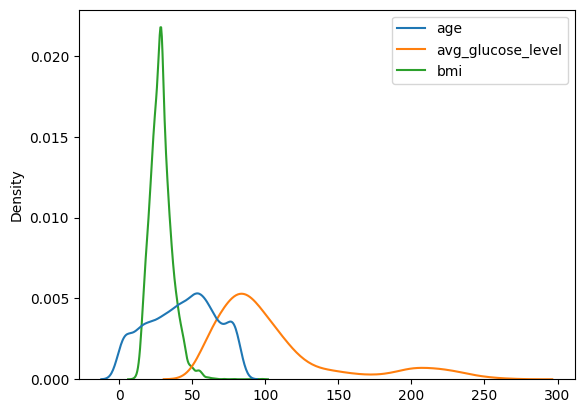

In [31]:
sns.kdeplot(df[numerical])

In [33]:
# lets check skewness of each variable 
df[numerical].skew()

age                 -0.137059
avg_glucose_level    1.572284
bmi                  1.076716
dtype: float64

- age has left skew and other have positive skew 

stroke
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: age, dtype: object

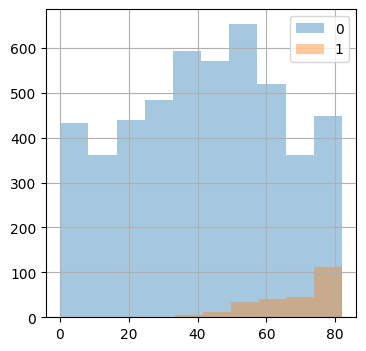

In [34]:
df.groupby('stroke').age.hist(alpha=0.4, legend=True, figsize=(4,4))

##### Bivariate Analysis

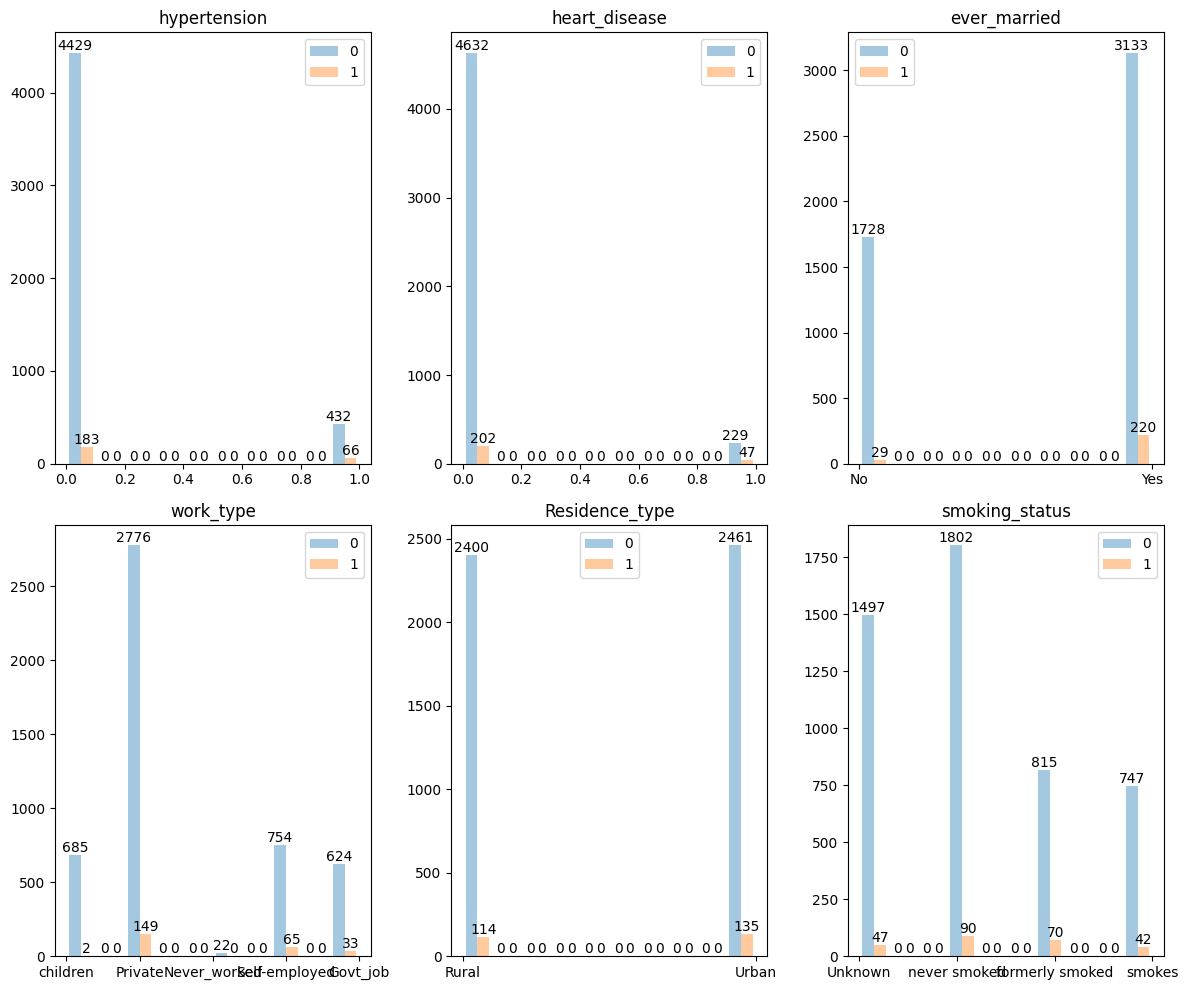

In [44]:
import math
n_col = 3
n_plots = len(categorical)
n_rows = math.ceil(n_plots/n_col)

fig, ax = plt.subplots(n_rows, n_col, figsize = (12,5*n_rows))
axes = ax.flat
for i, cat in enumerate(categorical):
    ax = axes[i]
    count, edges, bars = ax.hist([df[cat][df['stroke']==0], df[cat][df['stroke']==1]], histtype='bar', alpha = 0.4, label=(0,1))
    for b in bars:
        ax.bar_label(b)
    ax.legend()
    ax.set_title(cat)
# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].axis('off')

# Adjust layout and show
plt.tight_layout()
plt.show()

In [36]:
df['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

The data is highly imbalanced! 

In [37]:
x = df.drop(columns = ['stroke'], axis = 1)
x.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked


In [38]:
y = df['stroke']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: stroke, dtype: int64

### Model Evaulation

In [41]:
transformer = ColumnTransformer(transformers=[('imp', SimpleImputer(strategy='median'), ['age', 'avg_glucose_level', 'bmi']), ('o', OneHotEncoder(drop='first', handle_unknown='ignore'), ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status'])])

(5110, 10) (5110,)
>LR 0.838 (0.030)
>LDA 0.837 (0.030)
>SVM 0.801 (0.038)


C:\Users\iqra khan\AppData\Local\Temp\ipykernel_17412\1280068267.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names, showmeans=True)


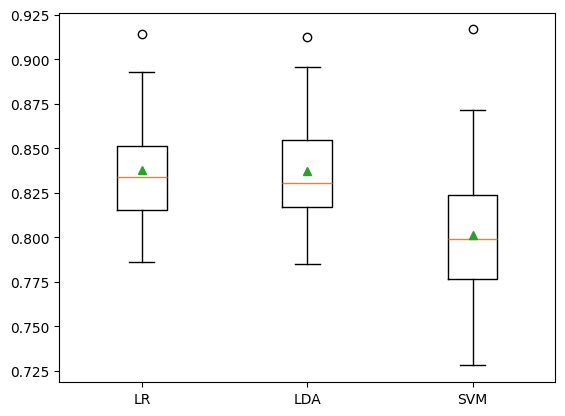

In [42]:
def load_data():
    df = pd.read_csv(r'C:\Users\iqra khan\OneDrive\Desktop\MSC\MachineLearning\Streamlit\Code\StrokePrediction\healthcare-dataset-stroke-data.csv')
    df = df.drop('id', axis = 1)

    categorical = [ 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status']
    numerical = ['avg_glucose_level', 'bmi','age']
    y= df['stroke']

    x = df.drop('stroke', axis=1)
    return x,y,categorical, numerical

def evaluate_model(x, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

def get_models():
    models, names = list(), list()
    models.append(LogisticRegression(solver='liblinear'))    
    names.append('LR')
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

x,y,categorical, numerical= load_data()
print(x.shape, y.shape)

models, names = get_models()
results = list()

for i in range(len(models)):

    over  = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)

    transformer = ColumnTransformer(transformers=[('imp',SimpleImputer(strategy='median'),numerical),('o',OneHotEncoder(drop='first'),categorical)])
    
    pipeline = Pipeline(steps=[('t', transformer),('p',PowerTransformer(method='yeo-johnson')),('over', over), ('under', under), ('m', models[i])])    

    scores = evaluate_model(x, y, pipeline)
    results.append(scores)

    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()


